   # LANGUAGE IDENTIFICATION CHALLENGE
      




# Introduction

In South Africa we have 11 official languages which are all considered equal, South Africa is a multicultural society that is characterised by its rich linguistic diversity. Language is an indispensable tool that can be used to deepen democracy and also contribute to the social, cultural, intellectual, economic and political life of the South African society.

Most South Africans are multilingual and able to speak at least two or more of the official languages,  With such a multilingual population, it is understandable that our systems and devices also communicate in multi-languages.

In this Hackathon challenge, we will take a text that is in any  South African  Official language and identify which language the text is in. This is an example of Natural Language Processing's Language Identification, the task of determining the natural language that a piece of text is written in.

# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import nltk
import string
from sklearn.pipeline import Pipeline
from nltk.tokenize import sent_tokenize

# feature extractioin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# Preprocessing
from collections import Counter
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

# classification models
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


# Hyperparameter tunning methods
from sklearn.model_selection import GridSearchCV

# metrics

from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from scikitplot.metrics import plot_confusion_matrix
%matplotlib inline

!pip install stopwordsiso
from nltk.corpus import stopwords
import stopwordsiso as stopwordz
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\CLLR A
[nltk_data]     Matumba\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading and processing data

In [2]:
train = pd.read_csv('train_set.csv')
test = pd.read_csv('test_set.csv')

In [3]:
train.head()

,lang_id,text
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...
2,eng,the province of kwazulu-natal department of tr...
3,nso,o netefatša gore o ba file dilo ka moka tše le...
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...


In [4]:
test.head()

,index,text
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.
3,4,Kube inja nelikati betingevakala kutsi titsini...
4,5,Winste op buitelandse valuta.


# Checking for missing values and data type

In [5]:
print('Train Info')
print('-'*60)
train.info()



Train Info
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33000 entries, 0 to 32999
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   lang_id  33000 non-null  object
 1   text     33000 non-null  object
dtypes: object(2)
memory usage: 515.8+ KB


In [6]:
print("Test Info")
print('-'*60)
test.info()
print('-'*60)


Test Info
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5682 entries, 0 to 5681
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   index   5682 non-null   int64 
 1   text    5682 non-null   object
dtypes: int64(1), object(1)
memory usage: 88.9+ KB
------------------------------------------------------------


There are no missing values from our data  and we have about 33 000 train entries and 5 682 observations for the test data.

In [7]:
ftrain = train.copy()
ftest = test.copy()

<AxesSubplot:xlabel='lang_id', ylabel='count'>

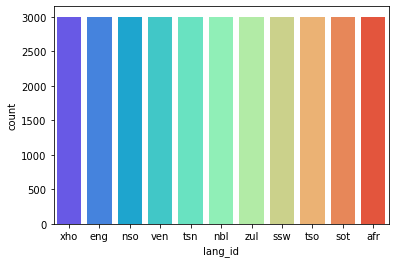

In [8]:
sns.countplot(x='lang_id',data=ftrain,palette='rainbow')

# For every language we are checking for unique values

In [9]:
train['lang_id'].value_counts()

afr    3000
sot    3000
nso    3000
eng    3000
ssw    3000
xho    3000
tsn    3000
zul    3000
ven    3000
tso    3000
nbl    3000
Name: lang_id, dtype: int64

In [10]:
ftrain.shape,ftest.shape

((33000, 2), (5682, 2))

In [11]:
ftrain.columns

Index(['lang_id', 'text'], dtype='object')

# Preparing  data for modeling ( Data Cleaning)

Removing Blank Spaces


In [12]:
### returns a list of indexes where there are blank spaces.

def drop_blank(df):
    blanks=[]
    for i, label,value in df.itertuples():
        if type(value)==str:
            if value.isspace():
                blanks.append(i)
        return blanks

In [13]:
#Drop Blank spaces in the train data set
train.drop(drop_blank(train),inplace=True)

In [14]:
#Drop Blank spaces in the train data set
test.drop(drop_blank(test),inplace=True)

### Split text separated by hypens

In [15]:
train['text_split'] = train['text'].str.split("-", )
test['text_split'] = test['text'].str.split("-", )

# Return to string from list
train['text_split'] = train.text_split.apply(lambda x: ' '.join([str(i) for i in x]))
test['text_split'] = test.text_split.apply(lambda x: ' '.join([str(i) for i in x]))

## Word Tokenization

In [16]:
train['tokens'] = train['text_split'].apply(nltk.word_tokenize)
test['tokens'] = test['text_split'].apply(nltk.word_tokenize)

##  We Remove Punctuations From Texts

In [17]:
train['tokens'] = train['tokens'].apply(lambda x : [token for token in x if token not in string.punctuation])
test['tokens'] = test['tokens'].apply(lambda x : [token for token in x if token not in string.punctuation])

In [18]:
train.head()

,lang_id,text,text_split,tokens
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqo siseko wenza amalungiselelo kumaziko ax...,"[umgaqo, siseko, wenza, amalungiselelo, kumazi..."
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,i dha iya kuba nobulumko bokubeka umsebenzi na...,"[i, dha, iya, kuba, nobulumko, bokubeka, umseb..."
2,eng,the province of kwazulu-natal department of tr...,the province of kwazulu natal department of tr...,"[the, province, of, kwazulu, natal, department..."
3,nso,o netefatša gore o ba file dilo ka moka tše le...,o netefatša gore o ba file dilo ka moka tše le...,"[o, netefatša, gore, o, ba, file, dilo, ka, mo..."
4,ven,khomishini ya ndinganyiso ya mbeu yo ewa maana...,khomishini ya ndinganyiso ya mbeu yo ewa maana...,"[khomishini, ya, ndinganyiso, ya, mbeu, yo, ew..."


In [19]:
test.head()

,index,text,text_split,tokens
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele...","Mmasepala, fa maemo a a kgethegileng a letlele...","[Mmasepala, fa, maemo, a, a, kgethegileng, a, ..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,"[Uzakwaziswa, ngokufaneleko, nakungafuneka, em..."
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.,Tshivhumbeo tshi fana na ngano dza vhathu.,"[Tshivhumbeo, tshi, fana, na, ngano, dza, vhathu]"
3,4,Kube inja nelikati betingevakala kutsi titsini...,Kube inja nelikati betingevakala kutsi titsini...,"[Kube, inja, nelikati, betingevakala, kutsi, t..."
4,5,Winste op buitelandse valuta.,Winste op buitelandse valuta.,"[Winste, op, buitelandse, valuta]"


## Remove one charater tokens

In [20]:
train['tokens'] = train['tokens'].apply(lambda x: [token for token in x if len(token) > 1])
test['tokens'] = test['tokens'].apply(lambda x: [token for token in x if len(token) > 1])

In [21]:
train.head(2)

,lang_id,text,text_split,tokens
0,xho,umgaqo-siseko wenza amalungiselelo kumaziko ax...,umgaqo siseko wenza amalungiselelo kumaziko ax...,"[umgaqo, siseko, wenza, amalungiselelo, kumazi..."
1,xho,i-dha iya kuba nobulumko bokubeka umsebenzi na...,i dha iya kuba nobulumko bokubeka umsebenzi na...,"[dha, iya, kuba, nobulumko, bokubeka, umsebenz..."


In [22]:
test.head()

,index,text,text_split,tokens
0,1,"Mmasepala, fa maemo a a kgethegileng a letlele...","Mmasepala, fa maemo a a kgethegileng a letlele...","[Mmasepala, fa, maemo, kgethegileng, letlelela..."
1,2,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,Uzakwaziswa ngokufaneleko nakungafuneka eminye...,"[Uzakwaziswa, ngokufaneleko, nakungafuneka, em..."
2,3,Tshivhumbeo tshi fana na ngano dza vhathu.,Tshivhumbeo tshi fana na ngano dza vhathu.,"[Tshivhumbeo, tshi, fana, na, ngano, dza, vhathu]"
3,4,Kube inja nelikati betingevakala kutsi titsini...,Kube inja nelikati betingevakala kutsi titsini...,"[Kube, inja, nelikati, betingevakala, kutsi, t..."
4,5,Winste op buitelandse valuta.,Winste op buitelandse valuta.,"[Winste, op, buitelandse, valuta]"


##  Stop Words

##### Converting texts to lowercase

In [23]:
stop_eng = stopwords.words('english')
stop_sotho = stopwordz.stopwords("st")
stop_zulu = stopwordz.stopwords("zu")
stop_afr = stopwordz.stopwords("af")

train['no_stopwords'] = train['tokens'].apply(lambda x: [word.lower() for word in x])

# Removing Stop Words
train['no_stopwords'] = train['tokens'].apply(lambda x: [item for item in x if item not in stop_eng])
train['no_stopwords'] = train['no_stopwords'].apply(lambda x: [item for item in x if item not in stop_sotho])
train['no_stopwords'] = train['no_stopwords'].apply(lambda x: [item for item in x if item not in stop_zulu])
train['no_stopwords'] = train['no_stopwords'].apply(lambda x: [item for item in x if item not in stop_afr])



#Test
test['no_stopwords'] = test['tokens'].apply(lambda x: [item for item in x if item not in stop_eng])
test['no_stopwords'] = test['no_stopwords'].apply(lambda x: [item for item in x if item not in stop_sotho])
test['no_stopwords'] = test['no_stopwords'].apply(lambda x: [item for item in x if item not in stop_zulu])
test['no_stopwords'] = test['no_stopwords'].apply(lambda x: [item for item in x if item not in stop_afr])

## Data Modelling

Separating X and Y

In [29]:
X = train['no_stopwords']
y = train['lang_id']
X_test = test['no_stopwords']


 Creating Training and validation data set

In [30]:
# Use 80% of the train set to train the model, 20% to validate.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state = 42)

In [31]:
# Convert to string list
X_train = list(X_train.apply(' '.join))
X_val = list(X_val.apply(' '.join))
X_test = list(X_test.apply(' '.join))

## Models


In [113]:
# LinearSVC Pipeline
Lsvc_tfidf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('scv', LinearSVC()),])
Lsvc_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,3)
                            )),('svc', LinearSVC()),])

# RandomForestClassifier Pipeline
rfc_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('rfc', RandomForestClassifier())])
rfc_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('rfc', RandomForestClassifier()),])

# DecisionTreeClassifier Pipeline
tree_tfidf = Pipeline([('tfidf', TfidfVectorizer()),('tree', DecisionTreeClassifier()),])
tree_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('tree', DecisionTreeClassifier()),])


# Ridge Pipeline
ridge_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('Ridge', RidgeClassifier())])
ridge_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,3)
                            )),('Ridge', RidgeClassifier()),])

#Naive Bayes Multinomial
nbm_tfidf = Pipeline([('tfidf', TfidfVectorizer()),('nbm', MultinomialNB()),])
nbm_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,3)
                            )),('nbm', MultinomialNB()),])


# Logistic Regression pipeline
logreg_tfidf = Pipeline([('tfidf', TfidfVectorizer()),('logistic', LogisticRegression()),])
logreg_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,3)
                            )),('logistic', LogisticRegression()),])

#SGD Classifiers
SGD_tfidf = Pipeline([('CountVec',TfidfVectorizer(max_features=180000) ),('SGD', SGDClassifier()),])
SGD_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'char', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,3)
                            )),('SGD', SGDClassifier()),])

# Support Vector Classifier Pipeline
svc_tfidf = Pipeline([('tfidf', TfidfVectorizer()), ('SVC', SVC())])
svc_count = Pipeline([('CountVec',  CountVectorizer(analyzer = 'word', 
                             tokenizer = None, 
                             preprocessor = None, 
                             stop_words = None, 
                             max_features = 180000,
                             min_df = 1,
                             ngram_range = (1,2)
                            )),('SVC', SVC()),])



## Training Our Models.

##### LinearSVC pipeline

In [33]:
# training the LinearSVC pipeline
Lsvc_tfidf.fit(X_train, y_train)
Lsvc_count.fit(X_train, y_train)

Pipeline(steps=[('CountVec',
                 CountVectorizer(max_features=180000, ngram_range=(1, 3))),
                ('svc', LinearSVC())])

###### Naive Bayes Multinomial pipeline

In [34]:
# training the Naive Bayes Multinomial pipeline
nbm_tfidf.fit(X_train, y_train)
nbm_count.fit(X_train, y_train)

Pipeline(steps=[('CountVec',
                 CountVectorizer(max_features=180000, ngram_range=(1, 3))),
                ('nbm', MultinomialNB())])

##### Ridge pipeline

In [35]:
# training the Ridge classifier
ridge_tfidf.fit(X_train, y_train)
ridge_count.fit(X_train, y_train)

Pipeline(steps=[('CountVec',
                 CountVectorizer(max_features=180000, ngram_range=(1, 3))),
                ('Ridge', RidgeClassifier())])

##### Logistic pipeline

In [41]:
# training the logistic regression pipeline
logreg_tfidf.fit(X_train, y_train)
logreg_count.fit(X_train, y_train)

C:\Users\CLLR A Matumba\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('CountVec',
                 CountVectorizer(max_features=180000, ngram_range=(1, 3))),
                ('logistic', LogisticRegression())])

##### SGD Classifier

In [37]:
SGD_count.fit(X_train,y_train)
SGD_tfidf.fit(X_train,y_train)

Pipeline(steps=[('CountVec', TfidfVectorizer(max_features=180000)),
                ('SGD', SGDClassifier())])

##### Decision Tree pipeline

In [114]:

tree_tfidf.fit(X_train, y_train)
tree_count.fit(X_train, y_train)

Pipeline(steps=[('CountVec',
                 CountVectorizer(max_features=180000, ngram_range=(1, 2))),
                ('tree', DecisionTreeClassifier())])

##### Random Forest pipeline

In [39]:
rfc_tfidf.fit(X_train, y_train)
rfc_count.fit(X_train, y_train)

Pipeline(steps=[('CountVec',
                 CountVectorizer(max_features=180000, ngram_range=(1, 2))),
                ('rfc', RandomForestClassifier())])

##### Support Vector Classifier

In [40]:
svc_tfidf.fit(X_train, y_train)
svc_count.fit(X_train, y_train)

Pipeline(steps=[('CountVec',
                 CountVectorizer(max_features=180000, ngram_range=(1, 2))),
                ('SVC', SVC())])

## CountVectorizer Section

In [116]:
# calculating average scores for CountVectorizer

nbm_acc_cv =  accuracy_score(y_val,nbm_count.predict(X_val))
tree_acc_cv =  accuracy_score(y_val,tree_count.predict(X_val))
rfc_acc_cv = accuracy_score(y_val,rfc_count.predict(X_val))
lsvc_acc_cv = accuracy_score(y_val,Lsvc_count.predict(X_val))
log_acc_cv = accuracy_score(y_val, logreg_count.predict(X_val))
sgd_acc_cv = accuracy_score(y_val, SGD_count.predict(X_val))
svc_acc_cv = accuracy_score(y_val, svc_count.predict(X_val))
ridge_acc_cv = accuracy_score(y_val, ridge_count.predict(X_val))

CountVec = round(np.mean([nbm_acc_cv,tree_acc_cv,rfc_acc_cv,
                          lsvc_acc_cv,log_acc_cv,sgd_acc_cv,
                          svc_acc_cv, ridge_acc_cv]),4)

NotFittedError: Vocabulary not fitted or provided


## TFIDF Section

In [47]:
# calculating average scores for the TFIDF
nbm_acc_tf =  accuracy_score(y_val,nbm_tfidf.predict(X_val))
tree_acc_tf =  accuracy_score(y_val,tree_tfidf.predict(X_val))
rfc_acc_tf = accuracy_score(y_val,rfc_tfidf.predict(X_val))
lsvc_acc_tf = accuracy_score(y_val,Lsvc_tfidf.predict(X_val))
log_acc_tf = accuracy_score(y_val, logreg_tfidf.predict(X_val))
sgd_acc_tf = accuracy_score(y_val, SGD_tfidf.predict(X_val))
svc_acc_tf = accuracy_score(y_val, svc_tfidf.predict(X_val))
ridge_acc_tf = accuracy_score(y_val, ridge_tfidf.predict(X_val))

tfidf_avg_accuracy = round(np.mean([nbm_acc_tf,tree_acc_tf,rfc_acc_tf,
                                    lsvc_acc_tf,log_acc_tf,sgd_acc_tf,
                                    svc_acc_tf,ridge_acc_tf]),4)

## Comparing TFIDF and CountVectorizer

TFIDF AVG Score = 98.6 %
CountVectorizer AVG Score = 98.38 %


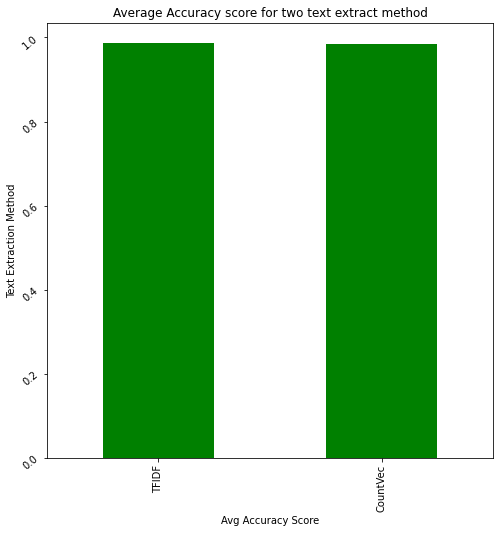

In [48]:
print("TFIDF AVG Score =", round(tfidf_avg_accuracy*100, 4), "%")
print("CountVectorizer AVG Score =", round(CountVec*100, 4), "%")

accuracy_dict = {'TFIDF':[tfidf_avg_accuracy], 'CountVec':[CountVec]}
accuracy_df = pd.DataFrame(accuracy_dict)
accuracy_df.T.plot(kind='bar', figsize = (8,8),legend = False, color = 'green')
plt.xlabel('Avg Accuracy Score')
plt.ylabel('Text Extraction Method')
plt.yticks(rotation = 40)
plt.title('Average Accuracy score for two text extract method')
plt.show()

In [83]:
# Validate model performance on TFIDF
nbm_prediction_tf = nbm_tfidf.predict(X_val) #Naive Bayes Multinomial predictions
tree_prediction_tf = tree_tfidf.predict(X_val) # DecisionTreeClassifier predictions
rfc_prediction_tf = rfc_tfidf.predict(X_val) # RandomForestClassifier predictions
Lsvc_prediction_tf = Lsvc_tfidf.predict(X_val) # LinearSVClassifier Predictions
logreg_prediction_tf = logreg_tfidf.predict(X_val) # Logistic regression predictions
SGD_prediction_tf = SGD_tfidf.predict(X_val) # SGD Classifier predictions
SVC_prediction_tf = svc_tfidf.predict(X_val) # Support vector machine predictions
ridge_prediction_tf = ridge_tfidf.predict(X_val) # Ridge predictions

In [84]:
# Validate model performance on CountVectorizer
nbm_prediction_cv = nbm_count.predict(X_val) # NaiveBayesMultinomial predictions
tree_prediction_cv = tree_count.predict(X_val) # DecisionTreeClassifier predictions
rfc_prediction_cv = rfc_count.predict(X_val) # RandomForestClassifier predictions
Lsvc_prediction_cv = Lsvc_count.predict(X_val) # LinearSVClassifier Predictions
logreg_prediction_cv = logreg_count.predict(X_val) # Logistic regression predictions
SGD_prediction_cv = SGD_count.predict(X_val) # SGD Classifier predictions
SVC_prediction_cv = svc_count.predict(X_val) # Support vector machine predictions
ridge_prediction_cv = ridge_count.predict(X_val) # Ridge predictions

# Evaluating each model


##### Naive Bayes Multinominal model


Naive Bayes Multinomial Model
               precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       0.98      1.00      0.99       583
         nso       1.00      1.00      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      1.00      1.00       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       1.00      1.00      1.00       609
         zul       1.00      0.98      0.99       590

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600



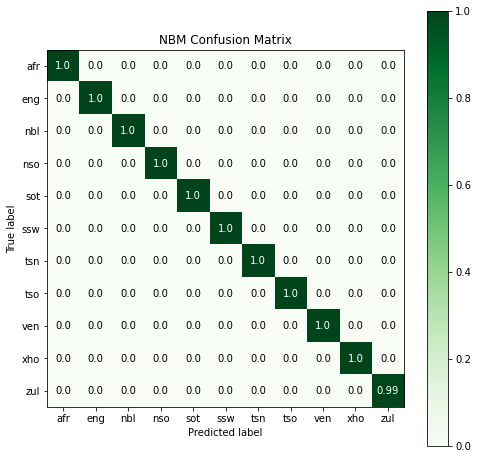

In [85]:
print('\nNaive Bayes Multinomial Model\n', classification_report(y_val, nbm_prediction_tf))
plot_confusion_matrix(y_val, nbm_prediction_cv, normalize=True,figsize=(8,8),cmap='Greens')
plt.title('NBM Confusion Matrix')
plt.show()

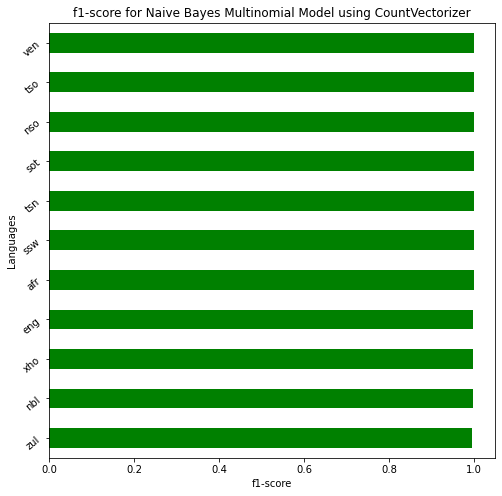

In [86]:
report_tree = classification_report(y_val, nbm_prediction_cv, output_dict=True)
df_nbm = pd.DataFrame(report_tree).transpose()
df_nbm.drop(['accuracy'], inplace = True)
df_nbm.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_nbm.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8, 8), color = 'Green')
plt.xlabel('f1-score')
plt.ylabel('Languages')
plt.yticks(rotation = 40)
plt.title('f1-score for Naive Bayes Multinomial Model using CountVectorizer')
plt.show()

In [87]:
# Performence of the model

nbm_acc_tf = round(accuracy_score(y_val, nbm_prediction_tf), 4)
print(f'\nOverall accuracy score for Naive Bayes Multinomial from TFIDF : {round(nbm_acc_tf*100, 4)}')
nbm_f1_tf = round(f1_score(y_val, nbm_prediction_tf, average="weighted"), 4)
print(f'\nWeighted avg f1 score Naive Bayes Multinomial from TFIDF: {(nbm_f1_tf)*100}')

nbm_acc_vec = round(accuracy_score(y_val, nbm_prediction_cv), 4)
print(f'\nOverall accuracy score for Naive Bayes Multinomial from CountVectorizer : {round(nbm_acc_vec*100, 4)}')
nbm_f1_vec = round(f1_score(y_val, nbm_prediction_cv, average="weighted"), 4)
print(f'\nWeighted avg f1 score Naive Bayes Multinomial from CountVectorizer: {round(nbm_f1_vec*100, 4)}')


Overall accuracy score for Naive Bayes Multinomial from TFIDF : 99.76

Weighted avg f1 score Naive Bayes Multinomial from TFIDF: 99.76

Overall accuracy score for Naive Bayes Multinomial from CountVectorizer : 99.83

Weighted avg f1 score Naive Bayes Multinomial from CountVectorizer: 99.83


#### LinearSCV Model


LinearSVC Model
               precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       0.99      0.98      0.99       583
         nso       1.00      1.00      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      0.99      1.00       584
         tsn       1.00      0.99      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       0.99      0.99      0.99       609
         zul       0.97      0.98      0.98       590

    accuracy                           0.99      6600
   macro avg       0.99      0.99      0.99      6600
weighted avg       0.99      0.99      0.99      6600



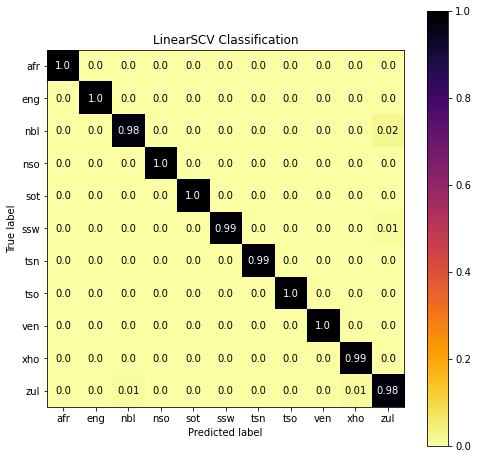

In [88]:
print('\nLinearSVC Model\n', classification_report(y_val, Lsvc_prediction_cv))
plot_confusion_matrix(y_val, Lsvc_prediction_cv, normalize=True,figsize=(8,8),cmap='inferno_r')
plt.title('LinearSCV Classification')
plt.show()

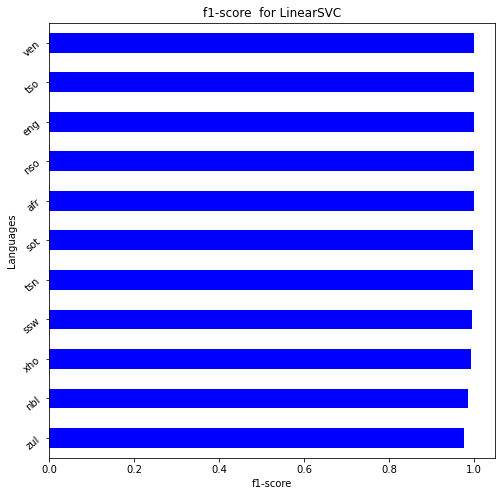

In [89]:
#Visualizing LinearSVC

report_svc = classification_report(y_val, Lsvc_prediction_cv, output_dict=True)
df_svc = pd.DataFrame(report_svc).transpose()
df_svc.drop(['accuracy'], inplace = True)
df_svc.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_svc.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8), color = 'blue')
plt.xlabel('f1-score')
plt.ylabel('Languages')
plt.yticks(rotation = 40)
plt.title('f1-score  for LinearSVC')
plt.show()

In [90]:
# Print the overall model performanceLsvc_prediction_cv
Lsvc_acc_tf = round(accuracy_score(y_val, Lsvc_prediction_tf), 4)
print(f'\nOverall accuracy score for LinearSVC Model from TFIDF : {round(Lsvc_acc_tf*100, 4)}')
Lsvc_acc_f1_tf = round(f1_score(y_val, Lsvc_prediction_tf, average="weighted"), 4)
print(f'\nWeighted avg f1 score LinearSVC Model from TFIDF: {round(Lsvc_acc_f1_tf*100, 4)}')

Lsvc_acc_vec = round(accuracy_score(y_val, Lsvc_prediction_cv), 4)
print(f'\nOverall accuracy score for LinearSVC Model from CountVectorizer : {round(Lsvc_acc_vec*100, 4)}')
Lsvc_f1_vec = round(f1_score(y_val, Lsvc_prediction_cv, average="weighted"), 4)
print(f'\nWeighted avg f1 score LinearSVC Model from CountVectorizer: {round(Lsvc_f1_vec*100, 4)}')


Overall accuracy score for LinearSVC Model from TFIDF : 99.71

Weighted avg f1 score LinearSVC Model from TFIDF: 99.71

Overall accuracy score for LinearSVC Model from CountVectorizer : 99.47

Weighted avg f1 score LinearSVC Model from CountVectorizer: 99.47


##### Logistic Regression Evaluation


Logistic Regression
               precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       0.99      0.98      0.99       583
         nso       1.00      0.99      1.00       625
         sot       0.99      1.00      1.00       618
         ssw       1.00      0.99      1.00       584
         tsn       0.99      0.99      0.99       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       1.00      0.99      0.99       609
         zul       0.96      0.99      0.98       590

    accuracy                           0.99      6600
   macro avg       0.99      0.99      0.99      6600
weighted avg       0.99      0.99      0.99      6600



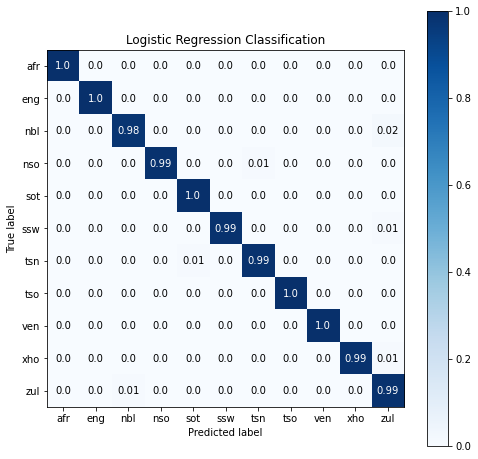

In [91]:
# Print a classification report
print('\nLogistic Regression\n', classification_report(y_val, logreg_prediction_cv))
plot_confusion_matrix(y_val, logreg_prediction_cv, normalize=True,figsize=(8,8),cmap='Blues')
plt.title('Logistic Regression Classification')
plt.show()

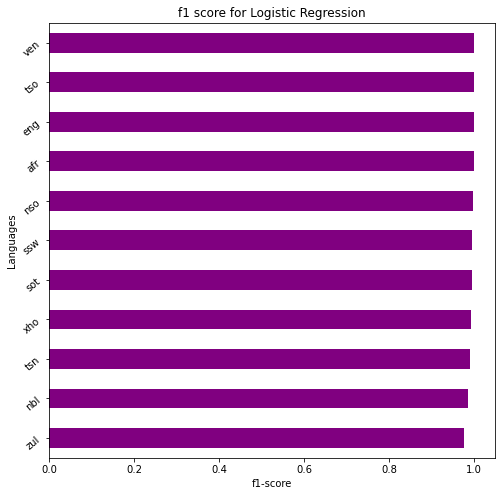

In [92]:
# Visual represetation of of the f1 score for each class
report_logreg = classification_report(y_val, logreg_prediction_cv, output_dict=True)
df_logreg = pd.DataFrame(report_logreg).transpose()
df_logreg.drop(['accuracy'], inplace = True)
df_logreg.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_logreg.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8), color = 'purple')
plt.xlabel('f1-score')
plt.ylabel('Languages')
plt.yticks(rotation = 40)
plt.title('f1 score for Logistic Regression')
plt.show()

In [93]:

# Print the overall model performanceLsvc_prediction_cv
logreg_acc_tf = round(accuracy_score(y_val, logreg_prediction_tf), 4)
print(f'\nOverall accuracy score for Logistic Regression from TFIDF : {round(logreg_acc_tf*100, 4)}')
logreg_acc_f1_tf = round(f1_score(y_val, logreg_prediction_tf, average="weighted"), 4)
print(f'\nWeighted avg f1 score Logistic Regression from TFIDF: {round(logreg_acc_f1_tf*100, 4)}')

logreg_acc_vec = round(accuracy_score(y_val, logreg_prediction_cv), 4)
print(f'\nOverall accuracy score for Logistic Regression from CountVectorizer : {round(logreg_acc_vec*100, 4)}')
logreg_f1_vec = round(f1_score(y_val, logreg_prediction_cv, average="weighted"), 4)
print(f'\nWeighted avg f1 score Logistic Regression from CountVectorizer: {round(logreg_f1_vec*100, 4)}')


Overall accuracy score for Logistic Regression from TFIDF : 99.52

Weighted avg f1 score Logistic Regression from TFIDF: 99.52

Overall accuracy score for Logistic Regression from CountVectorizer : 99.35

Weighted avg f1 score Logistic Regression from CountVectorizer: 99.35


#### SGD Classifier Evaluation


SGD Classifier  Classification report :
               precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       0.99      0.99      0.99       583
         nso       1.00      1.00      1.00       625
         sot       1.00      1.00      1.00       618
         ssw       1.00      1.00      1.00       584
         tsn       0.99      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       0.99      0.99      0.99       609
         zul       0.99      0.99      0.99       590

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600



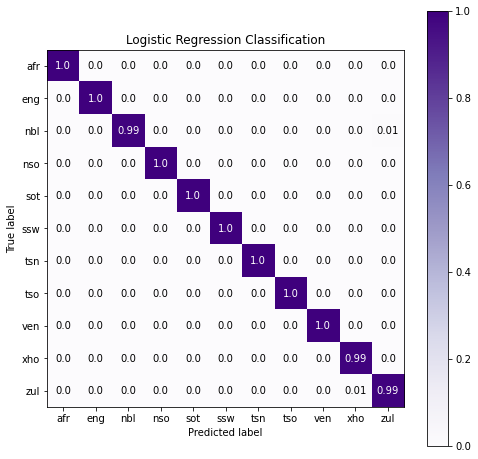

In [94]:
# The classification report 
print('\nSGD Classifier  Classification report :\n', classification_report(y_val, SGD_prediction_cv))
plot_confusion_matrix(y_val, SGD_prediction_cv, normalize=True,figsize=(8,8),cmap='Purples')
plt.title('Logistic Regression Classification')
plt.show()

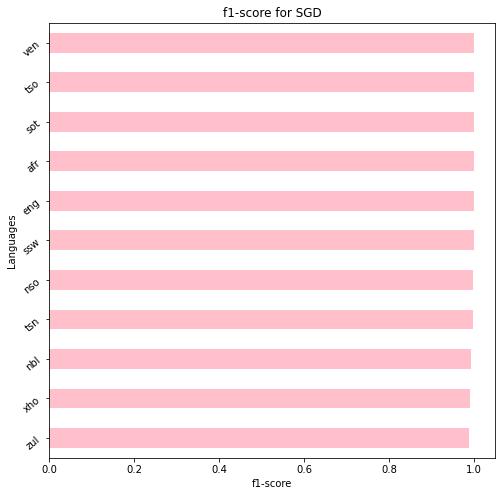

In [95]:
# Visual represetation of of the f1 score for language
report_sgd = classification_report(y_val, SGD_prediction_cv, output_dict=True)
df_sgd = pd.DataFrame(report_sgd).transpose()
df_sgd.drop(['accuracy'], inplace = True)
df_sgd.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_sgd.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8), color = 'pink')
plt.xlabel('f1-score')
plt.ylabel('Languages')
plt.yticks(rotation = 40)
plt.title('f1-score for SGD')
plt.show()

In [96]:
# Print the overall model performanceLsvc_prediction_cvSGD

SGD_acc_tf = round(accuracy_score(y_val, SGD_prediction_tf), 4)
print(f'\nOverall accuracy score for SGD Classifier from TFIDF : {round(SGD_acc_tf*100, 4)}')
SGD_acc_f1_tf = round(f1_score(y_val, SGD_prediction_tf, average="weighted"), 4)
print(f'\nWeighted avg f1 score SGD Classifier from TFIDF: {round(SGD_acc_f1_tf*100, 4)}')

SGD_acc_vec = round(accuracy_score(y_val, SGD_prediction_cv), 4)
print(f'\nOverall accuracy score for SGD Classifier from CountVectorizer : {round(SGD_acc_vec*100, 4)}')
SGD_f1_vec = round(f1_score(y_val, SGD_prediction_cv, average="weighted"), 4)
print(f'\nWeighted avg f1 score SGD Classifier from CountVectorizer: {round(SGD_f1_vec*100, 4)}')


Overall accuracy score for SGD Classifier from TFIDF : 99.71

Weighted avg f1 score SGD Classifier from TFIDF: 99.71

Overall accuracy score for SGD Classifier from CountVectorizer : 99.67

Weighted avg f1 score SGD Classifier from CountVectorizer: 99.67


##### Random Forest Evaluation


RandomForestClassifier
               precision    recall  f1-score   support

         afr       0.99      0.99      0.99       583
         eng       0.98      0.98      0.98       615
         nbl       0.99      0.91      0.95       583
         nso       1.00      0.99      0.99       625
         sot       0.97      1.00      0.99       618
         ssw       1.00      0.93      0.96       584
         tsn       0.99      0.98      0.98       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       0.99      0.93      0.96       609
         zul       0.81      0.97      0.88       590

    accuracy                           0.97      6600
   macro avg       0.97      0.97      0.97      6600
weighted avg       0.97      0.97      0.97      6600



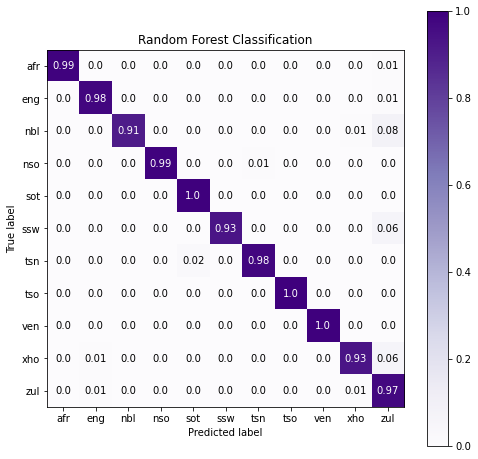

In [97]:
print('\nRandomForestClassifier\n', classification_report(y_val, rfc_prediction_cv))
plot_confusion_matrix(y_val, rfc_prediction_cv, normalize=True,figsize=(8,8),cmap='Purples')
plt.title('Random Forest Classification')
plt.show()

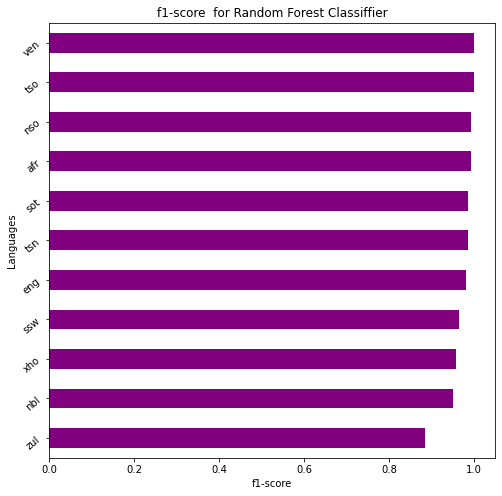

In [98]:
 # Visual represetation of of the f1 score for each class
report_rfc = classification_report(y_val, rfc_prediction_cv, output_dict=True)
df_rfc = pd.DataFrame(report_rfc).transpose()
df_rfc.drop(['accuracy'], inplace = True)
df_rfc.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_rfc.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8), color = 'purple')
plt.xlabel('f1-score')
plt.ylabel('Languages')
plt.yticks(rotation = 40)
plt.title('f1-score  for Random Forest Classiffier')
plt.show()

In [99]:
# Print the overall model performance
random_forest_acc_tf = round(accuracy_score(y_val, rfc_prediction_tf), 4)
print(f'\nOverall accuracy score for RandomForestClassifier from TFIDF : {round(random_forest_acc_tf*100, 4)}')
random_forest_acc_f1_tf = round(f1_score(y_val, rfc_prediction_tf, average="weighted"), 4)
print(f'\nWeighted avg f1 score RandomForestClassifier from TFIDF: {round(random_forest_acc_f1_tf*100, 4)}')

random_forest_acc_vec = round(accuracy_score(y_val, rfc_prediction_cv), 4)
print(f'\nOverall accuracy score for RandomForestClassifier from CountVectorizer : {round(random_forest_acc_vec*100, 4)}')
random_forest_f1_vec = round(f1_score(y_val, rfc_prediction_cv, average="weighted"), 4)
print(f'\nWeighted avg f1 score RandomForestClassifier from CountVectorizer: {round(random_forest_f1_vec*100, 4)}')


Overall accuracy score for RandomForestClassifier from TFIDF : 97.17

Weighted avg f1 score RandomForestClassifier from TFIDF: 97.23

Overall accuracy score for RandomForestClassifier from CountVectorizer : 97.14

Weighted avg f1 score RandomForestClassifier from CountVectorizer: 97.2


##### Support Vector Classfier Evaluation


Support Vector Classifier Classification report :
               precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       0.99      0.98      0.99       583
         nso       1.00      0.99      1.00       625
         sot       0.99      1.00      1.00       618
         ssw       1.00      0.99      1.00       584
         tsn       1.00      0.99      0.99       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       1.00      0.99      1.00       609
         zul       0.96      0.99      0.98       590

    accuracy                           0.99      6600
   macro avg       0.99      0.99      0.99      6600
weighted avg       0.99      0.99      0.99      6600



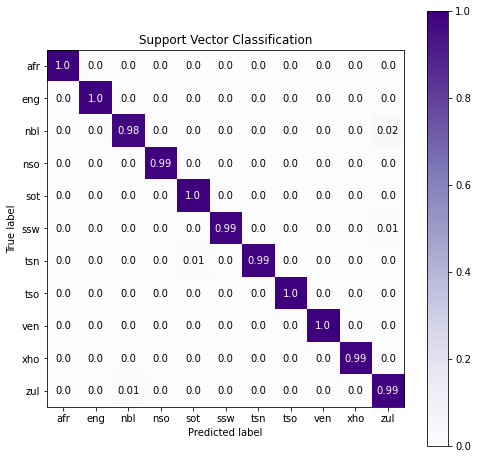

In [100]:
# The classification report 
print('\nSupport Vector Classifier Classification report :\n', classification_report(y_val, SVC_prediction_tf))
plot_confusion_matrix(y_val, SVC_prediction_tf, normalize=True,figsize=(8,8),cmap='Purples')
plt.title('Support Vector Classification')
plt.show()

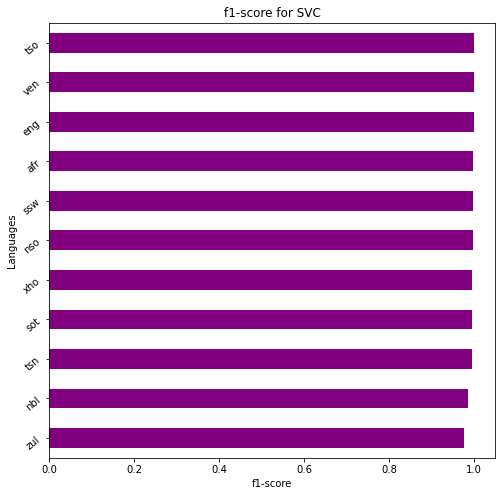

In [101]:

# Visual represetation of of the f1 score for language
report_svc = classification_report(y_val, SVC_prediction_tf, output_dict=True)
df_SVC = pd.DataFrame(report_svc).transpose()
df_SVC.drop(['accuracy'], inplace = True)
df_SVC.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_SVC.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8), color = 'purple')
plt.xlabel('f1-score')
plt.ylabel('Languages')
plt.yticks(rotation = 40)
plt.title('f1-score for SVC')
plt.show()

In [102]:
# Print the overall model performanceLsvc_prediction_cvSGD
SVC_acc_tf = round(accuracy_score(y_val, SVC_prediction_tf), 4)
print(f'\nOverall accuracy score for Support Vector Classifier from TFIDF : {round(SVC_acc_tf*100, 4)}')
SVC_acc_f1_tf = round(f1_score(y_val, SVC_prediction_tf, average="weighted"), 4)
print(f'\nWeighted avg f1 score Support Vector Classifier from TFIDF: {round(SVC_acc_f1_tf*100, 4)}')

SVC_acc_vec = round(accuracy_score(y_val, SVC_prediction_cv), 4)
print(f'\nOverall accuracy score for Support Vector Classifier from CountVectorizer : {round(SVC_acc_vec*100, 4)}')
SVC_f1_vec = round(f1_score(y_val, SVC_prediction_cv, average="weighted"), 4)
print(f'\nWeighted avg f1 score Support Vector Classifier from CountVectorizer: {round(SVC_f1_vec*100, 4)}')


Overall accuracy score for Support Vector Classifier from TFIDF : 99.41

Weighted avg f1 score Support Vector Classifier from TFIDF: 99.41

Overall accuracy score for Support Vector Classifier from CountVectorizer : 98.02

Weighted avg f1 score Support Vector Classifier from CountVectorizer: 98.06


#### Decision Tree Evaluation


Decision Tree
               precision    recall  f1-score   support

         afr       0.99      0.97      0.98       583
         eng       0.97      0.93      0.95       615
         nbl       0.92      0.88      0.90       583
         nso       0.99      0.96      0.97       625
         sot       0.94      0.99      0.97       618
         ssw       0.97      0.89      0.93       584
         tsn       0.94      0.97      0.96       598
         tso       1.00      0.99      0.99       561
         ven       0.99      0.98      0.98       634
         xho       0.94      0.89      0.91       609
         zul       0.73      0.92      0.81       590

    accuracy                           0.94      6600
   macro avg       0.95      0.94      0.94      6600
weighted avg       0.95      0.94      0.94      6600



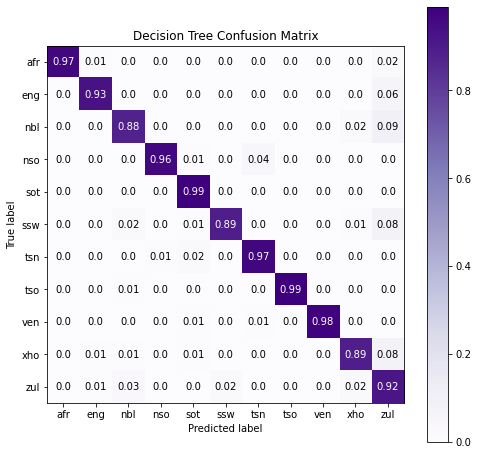

In [103]:
print('\nDecision Tree\n', classification_report(y_val, tree_prediction_cv))
plot_confusion_matrix(y_val, tree_prediction_cv, normalize=True,figsize=(8,8),cmap='Purples')
plt.title('Decision Tree Confusion Matrix')
plt.show()

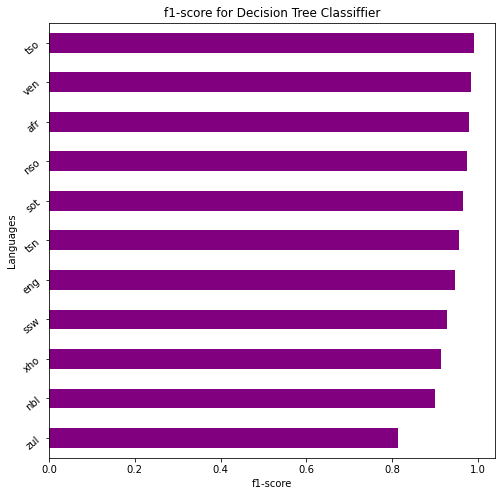

In [104]:
# # Visual represetation of of the f1 score for each class
report_tree = classification_report(y_val, tree_prediction_cv, output_dict=True)
df_tree = pd.DataFrame(report_tree).transpose()
df_tree.drop(['accuracy'], inplace = True)
df_tree.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_tree.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8), color = 'purple')
plt.xlabel('f1-score')
plt.ylabel('Languages')
plt.yticks(rotation = 40)
plt.title('f1-score for Decision Tree Classiffier')
plt.show()

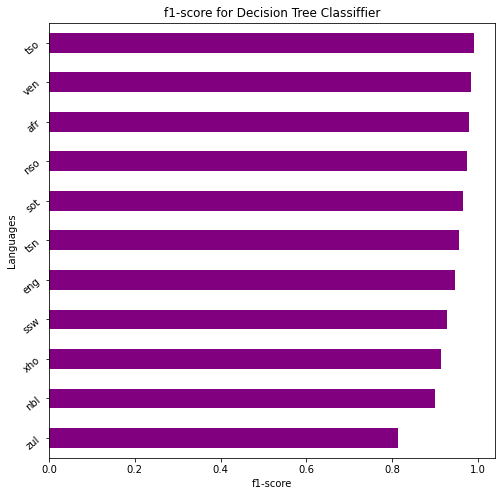

In [105]:
# Visual represetation of of the f1 score for each class
report_tree = classification_report(y_val, tree_prediction_cv, output_dict=True)
df_tree = pd.DataFrame(report_tree).transpose()
df_tree.drop(['accuracy'], inplace = True)
df_tree.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_tree.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8), color = 'purple')
plt.xlabel('f1-score')
plt.ylabel('Languages')
plt.yticks(rotation = 40)
plt.title('f1-score for Decision Tree Classiffier')
plt.show()

#### Ridge Classifier Evaluation


Ridge Classifier  Classification report :
               precision    recall  f1-score   support

         afr       1.00      1.00      1.00       583
         eng       1.00      1.00      1.00       615
         nbl       1.00      0.98      0.99       583
         nso       1.00      0.99      1.00       625
         sot       0.99      1.00      1.00       618
         ssw       0.99      0.99      0.99       584
         tsn       1.00      1.00      1.00       598
         tso       1.00      1.00      1.00       561
         ven       1.00      1.00      1.00       634
         xho       1.00      0.99      1.00       609
         zul       0.97      0.99      0.98       590

    accuracy                           1.00      6600
   macro avg       1.00      1.00      1.00      6600
weighted avg       1.00      1.00      1.00      6600



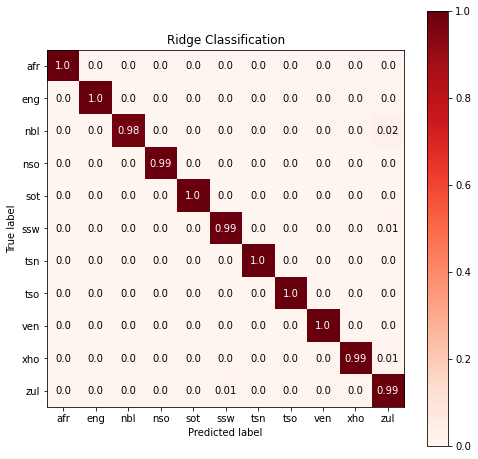

In [106]:
# The classification report 
print('\nRidge Classifier  Classification report :\n', classification_report(y_val, ridge_prediction_cv))
plot_confusion_matrix(y_val, ridge_prediction_cv, normalize=True,figsize=(8,8),cmap='Reds')
plt.title('Ridge Classification')
plt.show()

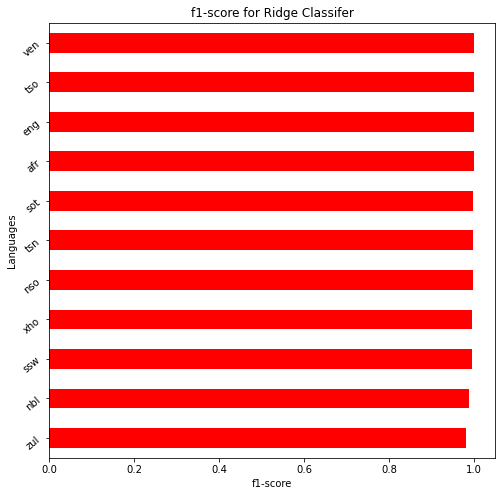

In [107]:
# Visual represetation of of the f1 score for each class
report_ridge = classification_report(y_val, ridge_prediction_cv, output_dict=True)
df_ridge = pd.DataFrame(report_ridge).transpose()
df_ridge.drop(['accuracy'], inplace = True)
df_ridge.sort_values(by=['f1-score'],ascending=True, inplace = True)
df_ridge.drop(['weighted avg','macro avg'])['f1-score'].plot(kind='barh', figsize = (8,8), color = 'red')
plt.xlabel('f1-score')
plt.ylabel('Languages')
plt.yticks(rotation = 40)
plt.title('f1-score for Ridge Classifer')
plt.show()

In [108]:
# Print the overall model 
ridge_acc_tf = round(accuracy_score(y_val, ridge_prediction_tf), 4)
print(f'\nOverall accuracy score for Ridge Classifier from TFIDF : {round(ridge_acc_tf*100, 4)}')
ridge_acc_f1_tf = round(f1_score(y_val, ridge_prediction_tf, average="weighted"), 4)
print(f'\nWeighted avg f1 score Ridge Classifier from TFIDF: {round(ridge_acc_f1_tf*100, 4)}')

ridge_acc_vec = round(accuracy_score(y_val, ridge_prediction_cv), 4)
print(f'\nOverall accuracy score for Ridge Classifier from CountVectorizer : {round(ridge_acc_vec*100, 4)}')
ridge_f1_vec = round(f1_score(y_val, ridge_prediction_cv, average="weighted"), 4)
print(f'\nWeighted avg f1 score Ridge Classifier from CountVectorizer: {round(ridge_f1_vec*100, 4)}')


Overall accuracy score for Ridge Classifier from TFIDF : 99.71

Weighted avg f1 score Ridge Classifier from TFIDF: 99.71

Overall accuracy score for Ridge Classifier from CountVectorizer : 99.52

Weighted avg f1 score Ridge Classifier from CountVectorizer: 99.52


In [109]:
y_pred = ridge_tfidf.predict(X_test)
test['lang_id'] = y_pred
#test[['index','lang_id']].to_csv('Ridge Classifier_tfidf.csv', index=False)
test[['index','lang_id']]

,index,lang_id
0,1,tsn
1,2,nbl
2,3,ven
3,4,ssw
4,5,afr
...,...,...
5677,5678,eng
5678,5679,nso
5679,5680,sot
5680,5681,sot


# Model Comparison

In [111]:
# Creating a dataframe with our models and their performances metrics
classifier_scores = {'Classifiers':['Naive Bayes Multinomial Model', 'Decision Tree', 'Random Forest','LinearSVC',
                                    'Logistic Regression','Stochastic Gradient Descent',
                                    'Support Vector Classifier','Ridge Classifier'],
                    'Accuracy on CV':[nbm_acc_vec, tree_prediction_acc_vec,random_forest_acc_vec,
                                Lsvc_acc_vec,logreg_acc_vec, SGD_acc_vec, SVC_acc_vec, ridge_acc_vec],
                     'F1 Score on CV':[nbm_f1_vec, tree_prediction_f1_vec,random_forest_f1_vec,
                                       Lsvc_f1_vec,logreg_f1_vec, SGD_f1_vec, SVC_f1_vec, ridge_f1_vec],
                    'Accuracy on TFIDF':[nbm_acc_tf, decison_tree_acc_tf,random_forest_acc_tf,
                                Lsvc_acc_tf,logreg_acc_tf, SGD_acc_tf, SVC_acc_tf, ridge_acc_tf],
                     'F1 Score on TFIDF':[nbm_f1_tf, tree_prediction_f1_vec,random_forest_acc_f1_tf,
                                       Lsvc_acc_f1_tf,logreg_acc_f1_tf, SGD_acc_f1_tf, SVC_acc_f1_tf, ridge_acc_f1_tf]}
df= pd.DataFrame(classifier_scores)
df.sort_values(by=['F1 Score on CV'],ascending=False, inplace = True)
df

NameError: name 'tree_prediction_acc_vec' is not defined

In [81]:
df.set_index(df['Classifiers'], inplace = True)
df.drop(['Classifiers'],axis = 1)
df.plot(kind='barh', figsize = (8,8))
plt.xlabel('Score')
plt.yticks(rotation = 45)
plt.title('Classifier Perfomance')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.show()

NameError: name 'df' is not defined

#### Model Ensemblement

In [ ]:

models = [("Naive Bayes Multinomial",nbm_count), ("LinearSVC", Lsvc_count),("Ridge Classified",ridge_count)]

# Specify weights for weighted model averaging
model_weightings = np.array([0.1,0.3,0.6])

# building the voting classifier
Voting_classifier = VotingClassifier(estimators=models,weights=model_weightings)

In [82]:
# training and validate the voting classifier
Voting_classifier.fit(X_train, y_train)
voting_prediction = Voting_classifier.predict(X_val)

NameError: name 'Voting_classifier' is not defined

### Ensemblement Evaluation

In [ ]:
# The classification report 
print('\nVoting Classifier Classification report :\n', classification_report(y_val, voting_prediction))
plot_confusion_matrix(y_val, voting_prediction, normalize=True,figsize=(8,8),cmap='Purples')
plt.title('Voting Classifier')
plt.show()

#### Comments

A lot more languages are incorrectly predicted on the validatation set.

In [112]:
#Final Submission

y_pred = Voting_classifier.predict(X_test)
test['lang_id'] = y_pred
test[['index','lang_id']].to_csv('Xichavo_Hobyani_Classf_hack.csv', index=False)
test[['index','lang_id']]

NameError: name 'Voting_classifier' is not defined

# Conclusions


All models perform relatively well on the train data, with all giving a score above 90% when being validated. However, the performace drops significantly for the unseen data when a submission is made on Kaggle. The best model; Naive Bayes Multinomial, performs at 99,76% F1 accuracy score on using TFIDF however this translates to 94% accuracy on Kaggle which it the best submission made, by far.

The models are overfitting and more work will be done to improve them for later submissions. A lot more experiments were done on this challenge but they were removed for the purpose of submitting this notebook